## Statistics with `statsmodels` and `scipy.stats`

Python has two mature and powerful packages for statistical inference that are general in nature - `scipy` and `statsmodels`. In fact, `pingouin` relies pretty much entirely on these packages for behind-the-scenes computation. Nothing beats diving into the details, so this section will take a close look at these packages.

- `statsmodels` allows users to fit a wide range of general and generalized linear models, random effects models, general additive models, and more. Often, one can fit these models using a "formula" style syntax that is inspired by `R`. As your statistical knowledge and comfort grows, you will want to progress to using this module as it is fully flexible - for example, it can estimate ordinal or Poisson regression models, which `pingouin` cannot. I find I use `statsmodels` daily.

- `scipy`, and in particular its `.stats` submodule, contain a range of useful statistical functions like `zscore`, `pearsonr`, and many more, as well as carrying a range of statistical distributions that allow you to estimate the probability of data in a clean and straightforward way. 

We will examine `statsmodels` in some detail here, in particular the workhorse of statistical inference - **ordinary least squares**, which is heavily used in psychology and beyond to estimate linear models.

### statsmodels - introduction to ordinary least squares and the formula interface
Ordinary least squares fits a line to data - a so-called *linear model*. The slope and intercepts of those lines can be use to make inferences about the relationship between variables.

`statsmodels` allows you to specify those relationships with a **formula string**. The formula interface to `statsmodels` is imported as `smf`. An example will make things clearer, using the `crash` dataset from the previous example. Lets load up the usual packages in addition to `statsmodels`.

In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf # the formula interface of statsmodels

crash = sns.load_dataset('car_crashes')

In [2]:
# Lets say we want to predict ins_losses from speeding, alcohol, and ins_premium
formula = 'ins_losses ~ 1 + speeding + alcohol + ins_premium'

This formula specifies that we predicting `ins_losses` from the additive model of `speeding`, `alcohol`, and `ins_premium` variables. Starting the formula a '1 +' simply means to compute a intercept. To build this model, we first need to pass it to the `ols` class from `statsmodels` and give it the associated data, and store it in a variable. Then, we need to call the `.fit()` method on this model - this will actually carry out the maths behind regression. Its easy to do this in one step. Once done, we can access the `.summary()` method and look at the model. `statsmodels` produces an in-depth output that contains all the data we need for analysis - particularly the coefficients, $R^2$, $F$ values, and degrees of freedom.

In [3]:
# Build a model and fit it at the same time.
model = smf.ols(formula, data=crash).fit()

# Examine the results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ins_losses   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     9.959
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           3.40e-05
Time:                        01:07:26   Log-Likelihood:                -223.14
No. Observations:                  51   AIC:                             454.3
Df Residuals:                      47   BIC:                             462.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      58.3212     17.892      3.260      0.002      22.327      94.315
speeding       -0.2978      1.893     -0.157      0.876      -4.106       3.510
alcohol         0.1428      2.235      0.064      0.949      -4.353       4.639
ins_premium     0.0868      0.016      5.375      0.000       0.054       0.119
==============================================================================
Omnibus:                        0.929   Durbin-Watson:                   2.253
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.953
Skew:                           0.297   Prob(JB):                        0.621
Kurtosis:                       2.689   Cond. No.                     5.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`statsmodels` produces an in-depth output that contains all the data we need for analysis - particularly the coefficients, $R^2$, $F$ values, and degrees of freedom, as well as other kinds of model fit such as $AIC$ - Akaike's Information Criterion, as well as $BIC$, the Bayesian Information Criterion.

#### The `ResultsWrapper` object
A fitted regression model, like the `model` variable above, is a special type of object from `statsmodels` called a `ResultsWrapper`:

In [4]:
type(model)

statsmodels.regression.linear_model.RegressionResultsWrapper

This object has a range of extremely useful attributes. For example, it contains the `.fittedvalues` and `.resid` attributes, which are the predicted values, and residuals (observed - predicted), respectively. Both are stored as `pandas` `Series` objects (one-dimensional DataFrames).

In [5]:
# Get predicted
display(model.fittedvalues.head())

# Get errors
display(model.resid.head())

0    125.019442
1    148.169326
2    135.174427
3    129.741571
4    133.771227
dtype: float64

0    20.060558
1   -14.239326
2   -24.824427
3    12.648429
4    31.858773
dtype: float64

This makes it very easy to check model assumptions graphically:

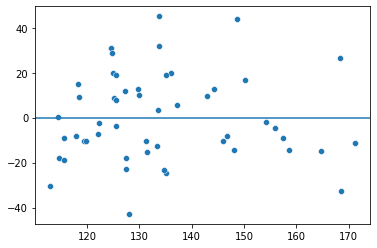

In [6]:
# Check residual plot of errors against predictions
plot = sns.scatterplot(x=model.fittedvalues, y=model.resid)
plot.axhline(0)

The `ResultsWrapper` contains a range of other useful attributes and methods, including robust covariances and tests for linear parameter contrasts. For example, we can test whether the `alcohol` coefficient is different from .10, and whether the `ins_premium` and `alcohol` coefficients are significantly different, using the `.t_test` method, as well as a formula string describing our tests:

In [7]:
model.t_test('ins_premium = alcohol, alcohol = .10')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0560      2.232     -0.025      0.980      -4.547       4.435
c1             0.1428      2.235      0.019      0.985      -4.353       4.639

#### Prediction Objects

The `ResultsWrapper` object also has a very helpful method named `.get_prediction`. This allows for inference on either the fitted data (call the method without any arguments) or on new, held out data (pass the DataFrame with the data to the method). 

The method returns a `PredictionResults` object, which contains the predicted values as well as their uncertainty in terms of the confidence intervals around both the average prediction and the prediction interval (where new observed values may fall). 

The `PredictionResults` object has a *further* method, `.summary_frame`, which will return the data in a DataFrame. Let's get the predictions of the insurance losses we modelled above, for the in-sample data:

In [8]:
# Get the in-sample predictions
in_sample_predictions = model.get_prediction().summary_frame()
display(in_sample_predictions.head())

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,125.019442,4.779806,115.403713,134.635170,83.594182,166.444702
1,148.169326,6.308884,135.477489,160.861163,105.923940,190.414712
2,135.174427,3.722046,127.686636,142.662218,94.190809,176.158045
3,129.741571,4.563009,120.561981,138.921161,88.415371,171.067771
4,133.771227,3.879437,125.966807,141.575648,92.728580,174.813875


There is a row for each observation. The `mean` column represents the prediction, and is identical to the `.fittedvalues` data. The `mean_se` is an estimate of the standard error of each prediction, and the `ci` columns represent the confidence interval around the mean. The `obs_ci` represents something different, the interval for within which new data points would be expected to fall (*not* the average).

#### Marginal predictions or counterfactuals
Lets take this a step further and explore the elegance of modelling for examining statistical relationships. We can explore the **marginal predictions** of variables by "holding constant" others, and use the tools we've seen above to get some uncertainty around this. Imagine that we are interested in the relationship between insurance premiums and insurance losses in accidents, while we account for speeding and alcohol. `ins_premium` was our only significant predictor in our model above (check `model.summary()` for a refresher), and we can examine what this looks like.

To do this, we need to take our fitted model and have it predict a 'counterfactual' world, where insurance premium varies but alcohol and speeding are held at some particular value. This 'particular value' can be anything we want, but it is typically the mean of a predictor variable. Below, we will ask the model to predict the insurance loss for the observed insurance premium data, but we will fix alcohol and speeding to be at their mean. Doing so with `pandas` is easy:


In [9]:
# Make a 'new' dataset to predict:
new_data = (crash
            .filter(items=['ins_losses', 'ins_premium']) # gets the existing data columns
            .assign(alcohol = crash['alcohol'].mean(),
                    speeding = crash['speeding'].mean())
           )

new_data.head()

,ins_losses,ins_premium,alcohol,speeding
0,145.08,784.55,4.886784,4.998196
1,133.93,1053.48,4.886784,4.998196
2,110.35,899.47,4.886784,4.998196
3,142.39,827.34,4.886784,4.998196
4,165.63,878.41,4.886784,4.998196


So we have a new dataset with the same insurance loss and insurance premium as before, but now we're imagining a world in which all the accidents took place where alcohol use was average, and speeding was also average. Note that these column names here **must** reflect the original column names used in the model fitting stage, or it will not work.

We next pass this data to the `get_prediction` method, and we immediately call the `summary_frame` method to get the predictions formatted nicely:

In [10]:
# Get new predictions
new_predictions = model.get_prediction(new_data).summary_frame()
new_predictions.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,125.607033,3.255652,119.057505,132.156561,84.784414,166.429652
1,148.942596,3.884950,141.127084,156.758108,107.897838,189.987353
2,135.578858,2.811930,129.921984,141.235732,94.889914,176.267801
3,129.320002,2.965204,123.354781,135.285222,88.587045,170.052959
4,133.751442,2.808058,128.102357,139.400526,93.063580,174.439303


It would be great to plot this data, but one tricky extra step is that plotting is made easier by sorting the predictions by the predictor of interest. One way to do this is to join everything into one dataset (the new data and the predictions) and plot *that*, like so:

In [11]:
# Join data together
new_predictions = pd.merge(left=new_data, right=new_predictions,
                           left_index=True, right_index=True).sort_values(by='ins_premium')

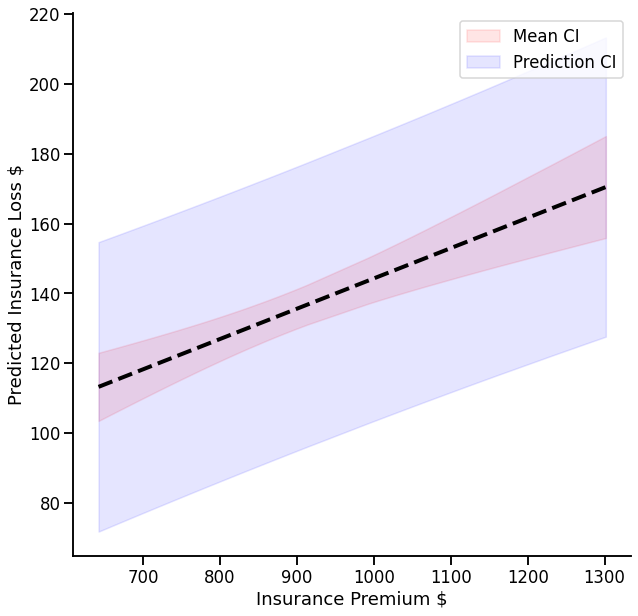

In [12]:
# Use context manager
with sns.plotting_context('talk'):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.despine(fig)
    
    # Seaborn lineplot to show the relationship
    sns.lineplot(x=new_predictions['ins_premium'], 
                 y=new_predictions['mean'], 
                 linestyle='dashed',
                 linewidth=4,
                 color='black',
                 ax=ax)
    
    # Fill between is an axis method that shades an area between two Y and one X dataset
    ax.fill_between(new_predictions['ins_premium'], 
                    new_predictions['mean_ci_lower'], 
                    new_predictions['mean_ci_upper'], 
                    alpha=.1, 
                    color='red', 
                    label='Mean CI')
    
    ax.fill_between(new_predictions['ins_premium'], 
                    new_predictions['obs_ci_lower'], 
                    new_predictions['obs_ci_upper'], 
                    alpha=.1, 
                    color='blue', 
                    label='Prediction CI')
    
    ax.legend() # show legend
    ax.set(ylabel='Predicted Insurance Loss $', xlabel='Insurance Premium $') # Set labels

There is a positive relationship here - accounting for speeding and alcohol, accidents with higher premiums result in greater losses. There is some greater uncertainty about the *mean* of this relationship at the extreme ends of the `ins_premium` variable; but its quite focused. The prediction intervals on the other hand are much wider - the model implies that, for example, an accident with a $900 premium (and, don't forget - average speeding and average alcohol use!) could lose anywhere between ~95 and ~170. 